# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

To identify the primary factors that drive used car prices, we frame the problem as a supervised regression task. The dependent variable is the sale price of each vehicle, and the independent variables (features) include mileage, engine size, condition, model year, brand, and other relevant descriptors.

We will fit Ridge (or LASSO) regression models to learn the mapping from features to price. Because the coefficients of a linear regression are directly interpretable, the magnitude and sign of each coefficient reveal the relative importance of the corresponding predictor.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

To understand the data, first we must profile the features of said data. This includes counting missing values, checking value types, and checking distributions to identify impossible or skewed values. Remove rows missing an extensive amount of relevant features, while imputing rows with only a few missing values. Then compare each predictor's correlation with the target variable to decide which features should remain to be used in modeling.

In [1]:
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer

import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/vehicles.csv")
print(df.shape)
df.info()

(426880, 18)
<class 'pandas.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  str    
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  str    
 5   model         421603 non-null  str    
 6   condition     252776 non-null  str    
 7   cylinders     249202 non-null  str    
 8   fuel          423867 non-null  str    
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  str    
 11  transmission  424324 non-null  str    
 12  VIN           265838 non-null  str    
 13  drive         296313 non-null  str    
 14  size          120519 non-null  str    
 15  type          334022 non-null  str    
 16  paint_color   296677 non-null  str    
 17  state         426880 non-null  str    
dtypes:

In [3]:
# Let's check the percentage of missing values in each column
df.isnull().mean() * 100

id               0.000000
region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64

<Axes: xlabel='year', ylabel='Count'>

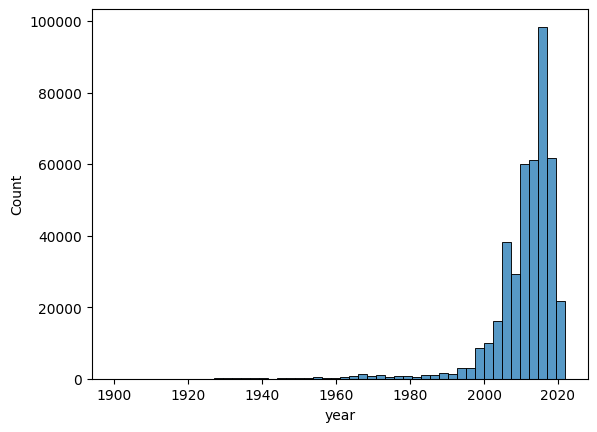

In [4]:
sns.histplot(df["year"], bins=50)

/Users/clifton/Documents/Berkeley/UCB-Module-11-Assignment/venv/lib/python3.14/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='price', ylabel='Count'>

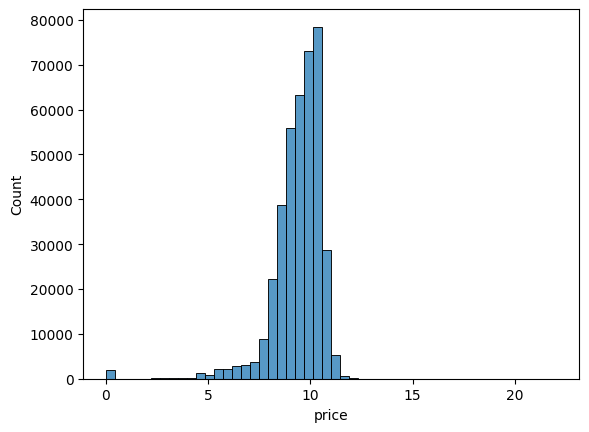

In [5]:
sns.histplot(np.log(df["price"]), bins=50)

/Users/clifton/Documents/Berkeley/UCB-Module-11-Assignment/venv/lib/python3.14/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='odometer', ylabel='Count'>

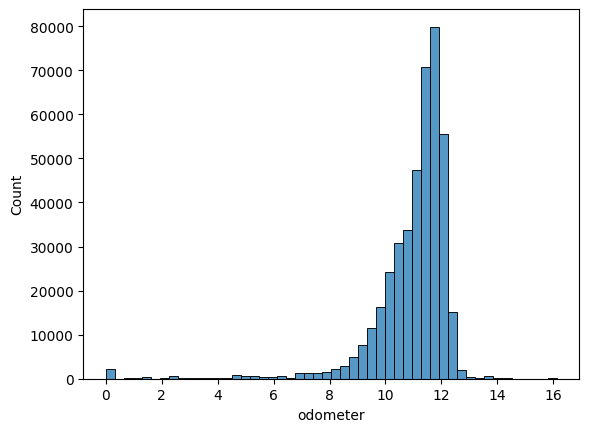

In [6]:
sns.histplot(np.log(df["odometer"]), bins=50)

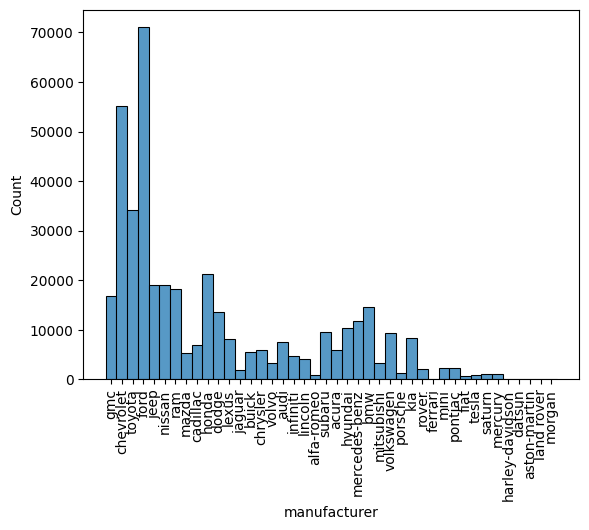

In [7]:
his = sns.histplot(df["manufacturer"], bins=50)
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='condition', ylabel='price'>

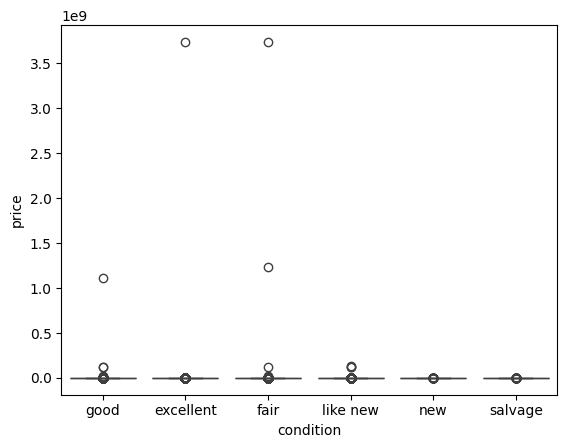

In [8]:
sns.boxplot(x=df["condition"], y=df["price"])

After examining the data, there are several observations that can be made:
- The histplot of the log transformation of price is left skewed
- The year is also left skewed, demonstrating most used cars are trending to newer
- Odometer is trending towards higher mileage cars
- Seeing a comparison of condition vs price any car that's better than 'fair' condition tends to be much higher in price

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [9]:
# Drop any duplicate rows
df.drop_duplicates(inplace=True)
# After doing so, we see there were no duplicates in the dataset
df.shape[0]

426880

After some exploration, we can observe there are some columns with a high
percentage of missing values. Let's drop any row with more than 25% of
missing values.

In [10]:
original_count = df.shape[0]
df = df.dropna(thresh=int(df.shape[1] * 0.75))
df.shape[0]

372156

Let's see how many rows have been deleted to determine if we removed too much.

In [11]:
rows_deleted = original_count - df.shape[0]
print(f"Number of rows deleted: {rows_deleted:,.0f}")
print(f"Percentage of rows deleted: {(rows_deleted / original_count) * 100:.1f}%")

Number of rows deleted: 54,724
Percentage of rows deleted: 12.8%


In [12]:
# Just to double check, let's see the mean of missing values
df.isnull().mean() * 100

id               0.000000
region           0.000000
price            0.000000
year             0.235654
manufacturer     3.233322
model            0.842389
condition       33.694741
cylinders       33.548834
fuel             0.444975
odometer         0.842657
title_status     1.859167
transmission     0.403863
VIN             31.329872
drive           21.108890
size            67.630778
type            10.939498
paint_color     20.836423
state            0.000000
dtype: float64

So we've handled a decent amount of the missing information. But there are still columns with >30% missing values in the data. What can we do? VIN is not going to helpful, we can drop that. The `size` column is exceedingly missing a value, not worth imputing, and we can drop it. Since `year` is an extremely important factor, and there is only 0.27% rows with missing values, we'll drop the rows that have missing years.

In [13]:
# Drop the VIN and size columns
df = df.drop(columns=["VIN", "size", "region"])
df = df.dropna(subset=["year", "odometer"])
for col in df.select_dtypes(include="str"):
    print(col, df[col].nunique())

manufacturer 42
model 26151
condition 6
cylinders 8
fuel 5
title_status 6
transmission 3
drive 3
type 13
paint_color 12
state 51


With some of the filtering of the data complete, and dropping unnecessary features, next is to impute columns that are still desired for modeling.

In [14]:
# Extract the numeric part of the cylinders column and create a new column for it
df["cylinders"] = df["cylinders"].str.extract(r"(\d+)")
df["cylinders"] = df["cylinders"].fillna("unknown")
df["cylinders_raw"] = df["cylinders"].fillna("unknown")
df["cylinders_num"] = df["cylinders_raw"].str.extract(r"(\d+)").astype("Int64")

# Convert the year column to integer type
df["year"] = df["year"].astype(int)

# Impute categorical columns
categorical_fill = [
    "manufacturer",
    "model",
    "condition",
    "drive",
    "paint_color",
    "type",
    "title_status",
    "fuel",
    "transmission",
]
for col in categorical_fill:
    df[col] = df[col].fillna("unknown")

df.isnull().mean() * 100

id                0.000000
price             0.000000
year              0.000000
manufacturer      0.000000
model             0.000000
condition         0.000000
cylinders         0.000000
fuel              0.000000
odometer          0.000000
title_status      0.000000
transmission      0.000000
drive             0.000000
type              0.000000
paint_color       0.000000
state             0.000000
cylinders_raw     0.000000
cylinders_num    33.813491
dtype: float64

In [15]:
# Remove outliers based on impossible prices
df = df[(df["price"] > 0) & (df["price"] < df["price"].quantile(0.99))]
df["price"].describe()

count    338080.000000
mean      18713.903529
std       13338.710907
min           1.000000
25%        7900.000000
50%       15990.000000
75%       27919.000000
max       66998.000000
Name: price, dtype: float64

We can see here that the years of the used cars are heavily left skewed.

We can see from a simple histogram here after cleaning and prepping the data that our data is right skewed. Which is good since that means our data is not being heavily influenced by outlier vehicles that are extremely expensive.

In [16]:
df["model"].nunique()

24581

After looking at the number of unique models, we see there is an extraordinary amount of unique models. This will be problematic if we attempt to One Hot encode the column. So we need to cut it down. We can do this by setting a threshold for models that appear over 100 times, anything below that will be considered 'rare' and grouped into it's own model called 'other'.

In [17]:
model_threshold = df["model"].value_counts().quantile(0.95)
rare_models = (
    df["model"].value_counts()[df["model"].value_counts() >= model_threshold].index
)
df["model"] = df["model"].where(df["model"].isin(rare_models), "other")
df["model"].unique()

<StringArray>
[   'sierra 1500 crew cab slt',              'silverado 1500',
         'silverado 1500 crew',        'tundra double cab sr',
                   'f-150 xlt', 'sierra 2500 hd extended cab',
       'silverado 1500 double',                      'tacoma',
       'colorado extended cab',        'corvette grand sport',
 ...
 's5 premium plus convertible',            'pacifica touring',
             'wrangler unlimi',       'mkz hybrid reserve ii',
        '1500 laramie 4x4 gas',       'lifted silverado 1500',
      '1500 sport 4x4 1/2 ton',   'f150 xlt 4x4 half ton gas',
 'lifted f150 xlt 4x4 1/2 ton',    'f150 xlt 4x4 1/2 ton gas']
Length: 1234, dtype: str

Now the number is drastically cut down, from 24,581 to 562. This means the encoding will be much smaller, and the regression models won't run into memory issues later on.

In [18]:
df = df[(df["odometer"] >= 0) & (df["odometer"] <= 1000000)]

In [19]:
from datetime import datetime

df["age"] = datetime.now().year - df["year"]
df["age"].sort_values().unique()

array([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 108, 110,
       111, 116, 117, 121, 125, 126])

There are multiple cars close to or over 100 years old, this could be skewing the data by including 'rare' or junk cars not relevant to the question being answered. It would be reasonable to have a cutoff for how old a car can be, let's say 40 years old. Anything older is either collector's cars, or unreasonable cars to be considered for the used car market.

In [20]:
df = df[df["age"] <= 40]
df["age"].sort_values().unique()

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40])

In [21]:
df.info()

<class 'pandas.DataFrame'>
Index: 330777 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             330777 non-null  int64  
 1   price          330777 non-null  int64  
 2   year           330777 non-null  int64  
 3   manufacturer   330777 non-null  str    
 4   model          330777 non-null  str    
 5   condition      330777 non-null  str    
 6   cylinders      330777 non-null  str    
 7   fuel           330777 non-null  str    
 8   odometer       330777 non-null  float64
 9   title_status   330777 non-null  str    
 10  transmission   330777 non-null  str    
 11  drive          330777 non-null  str    
 12  type           330777 non-null  str    
 13  paint_color    330777 non-null  str    
 14  state          330777 non-null  str    
 15  cylinders_raw  330777 non-null  str    
 16  cylinders_num  220174 non-null  Int64  
 17  age            330777 non-null  int64  
dtyp

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Split the data into train and test

In [22]:
X, y = (
    df.drop(columns=["id", "price", "year", "cylinders", "cylinders_raw"]),
    df["price"],
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

### Create pipelines to preprocess the columns

In [23]:
categorical_cols = X_train.select_dtypes(include=["str"]).columns
numerical_cols = X_train.select_dtypes(include=["number"]).columns
numerical_cols = numerical_cols.drop("cylinders_num")

numeric_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

cylinders_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="most_frequent")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    [
        ("num", numeric_pipeline, numerical_cols),
        ("cyl", cylinders_pipeline, ["cylinders_num"]),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=True),
            categorical_cols,
        ),
    ]
)
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

## Linear Regression

In [24]:
# Linear regression pipeline
linreg = Pipeline([("pre", preprocessor), ("linreg", LinearRegression())])
cv_scores_linear = cross_val_score(
    linreg, X_train, y_train, cv=5, scoring="r2", n_jobs=-1
)

linreg.fit(X_train, y_train)
linreg_pred = linreg.predict(X_test)
linreg_mae = mean_absolute_error(y_test, linreg_pred)
linreg_rmse = np.sqrt(mean_squared_error(y_test, linreg_pred))
linreg_std = np.std(cv_scores_linear)

print(f"Linear Regression R2: {linreg.score(X_test, y_test)} ± {linreg_std:.4f}")
print(f"Linear Regression CV R2: {np.mean(cv_scores_linear)}")
print(f"Linear Regression MAE: {linreg_mae}")
print(f"Linear Regression RMSE: {linreg_rmse}")

Linear Regression R2: 0.713482153013425 ± 0.0020
Linear Regression CV R2: 0.7087738947529454
Linear Regression MAE: 4594.74332024001
Linear Regression RMSE: 7145.971971230146


## Ridge Regression

In [25]:
ridge = Pipeline(
    [
        ("pre", preprocessor),
        ("model", RidgeCV(alphas=alphas, cv=5, scoring="r2")),
    ]
)
cv_scores_ridge = cross_val_score(
    ridge, X_train, y_train, cv=5, scoring="r2", n_jobs=-1
)

ridge.fit(X_train, y_train)
print("Best Ridge alpha:", ridge.named_steps["model"].alpha_)
print("Ridge R2:", ridge.score(X_test, y_test))

ridge_predict = ridge.predict(X_test)
ridge_mae = mean_absolute_error(y_test, ridge_predict)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_predict))
ridge_std = np.std(cv_scores_ridge)

print(f"Ridge CV R2: {np.mean(cv_scores_ridge)} ± {ridge_std:.4f}")
print(f"Ridge MAE: {ridge_mae}")
print(f"Ridge RMSE: {ridge_rmse}")

Best Ridge alpha: 1.0
Ridge R2: 0.7135432961908872
Ridge CV R2: 0.7087952754960926 ± 0.0020
Ridge MAE: 4594.391627347092
Ridge RMSE: 7145.2094519845905


## LASSO

In [26]:
lasso = Pipeline(
    [("pre", preprocessor), ("model", LassoCV(cv=5, n_jobs=-1, max_iter=20000))]
)

cv_scores_lasso = cross_val_score(
    lasso, X_train, y_train, cv=5, scoring="r2", n_jobs=-1
)

lasso.fit(X_train, y_train)

lasso_pred = lasso.predict(X_test)
lasso_mae = mean_absolute_error(y_test, lasso_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
lasso_std = np.std(cv_scores_lasso)

print(f"LASSO R2: {lasso.score(X_test, y_test)} ± {lasso_std:.4f}")
print(f"LASSO CV R2: {np.mean(cv_scores_lasso)}")
print(f"LASSO MAE: {lasso_mae}")
print(f"LASSO RMSE: {lasso_rmse}")

LASSO R2: 0.658228751363891 ± 0.0027
LASSO CV R2: 0.6537322229297132
LASSO MAE: 5379.998704343742
LASSO RMSE: 7804.646398283028


## CAT Boost

In [27]:
if os.path.exists("catboost_info"):
    shutil.rmtree("catboost_info")

cat_features = [X.columns.get_loc(col) for col in categorical_cols]

train_pool = Pool(X_train, y_train, cat_features=cat_features)
params = {
    "iterations": 2000,
    "depth": 6,
    "learning_rate": 0.05,
    "loss_function": "RMSE",
    "eval_metric": "R2",
    "random_seed": 42,
    "verbose": False,
}

cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    early_stopping_rounds=50,
    verbose=False,
)

best_iter = np.argmax(cv_results["test-R2-mean"])

cv_r2_mean = cv_results["test-R2-mean"].iloc[best_iter]
cv_r2_std = cv_results["test-R2-std"].iloc[best_iter]

print(f"CatBoost CV R2: {cv_r2_mean:.4f} ± {cv_r2_std:.4f}")
print(f"Best iteration from CV: {best_iter}")

cat_boost = CatBoostRegressor(
    iterations=best_iter,
    depth=6,
    learning_rate=0.05,
    loss_function="RMSE",
    random_seed=42,
    verbose=False,
)

cat_boost.fit(train_pool)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

cat_pred = cat_boost.predict(test_pool)
cat_mae = mean_absolute_error(y_test, cat_pred)
cat_rmse = np.sqrt(mean_squared_error(y_test, cat_pred))

print(f"CatBoost Test R2: {r2_score(y_test, cat_pred)}")
print(f"CatBoost Test MAE: {cat_mae}")
print(f"CatBoost Test RMSE: {cat_rmse}")

Training on fold [0/5]

bestTest = 0.855986209
bestIteration = 1999

Training on fold [1/5]

bestTest = 0.8540108548
bestIteration = 1999

Training on fold [2/5]

bestTest = 0.8548803546
bestIteration = 1999

Training on fold [3/5]

bestTest = 0.8571417029
bestIteration = 1998

Training on fold [4/5]

bestTest = 0.8602834783
bestIteration = 1999

CatBoost CV R2: 0.8565 ± 0.0024
Best iteration from CV: 1999
CatBoost Test R2: 0.8641297440598041
CatBoost Test MAE: 3061.406055895357
CatBoost Test RMSE: 4920.935420669841


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Here's a breakdown of the regression models' performance:
| Model | R2 | RMSE | MAE |
| --- | --- | --- | --- |
| Linear | 0.7135 | 7145.9720 | 4594.7433 |
| Ridge | 0.7135 | 7145.2095 | 4594.3916 |
| LASSO | 0.6582 | 7804.6464 | 5379.9987 |
| CatBoost | 0.8641 | 4920.9354 | 3061.4061 |

In [28]:
df_plot = pd.DataFrame({"Actual": y_test, "Predicted": cat_pred})

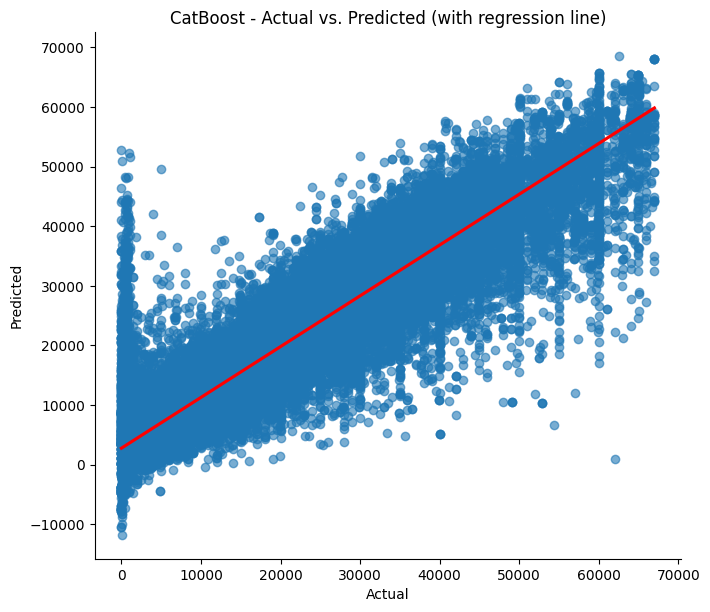

In [29]:
sns.lmplot(
    x="Actual",
    y="Predicted",
    data=df_plot,
    fit_reg=True,
    scatter_kws={"alpha": 0.6},
    line_kws={"color": "red"},
    height=6,
    aspect=1.2,
)
plt.title("CatBoost - Actual vs. Predicted (with regression line)")
plt.show()

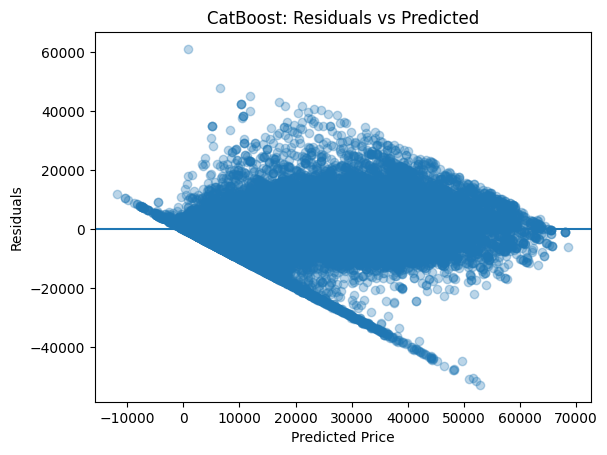

In [32]:
residuals = y_test - cat_pred

plt.figure()
plt.scatter(cat_pred, residuals, alpha=0.3)
plt.axhline(0)
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("CatBoost: Residuals vs Predicted")
plt.show()

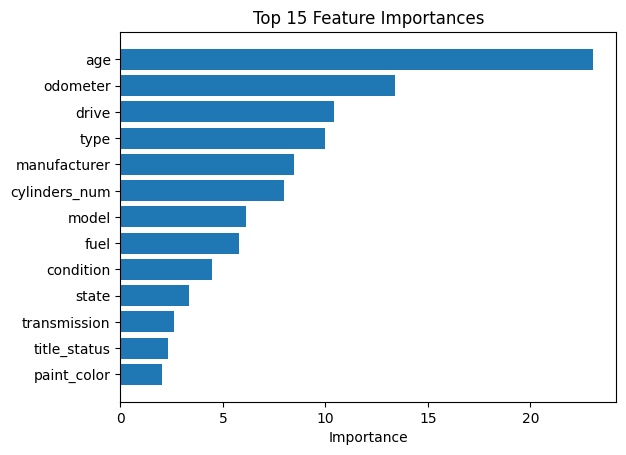

In [31]:
importances = cat_boost.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values(by="Importance", ascending=False)

plt.figure()
plt.barh(importance_df["Feature"][:15][::-1], importance_df["Importance"][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances")
plt.show()

Among all evaluated models, CatBoost achieved the strongest predictive performance with an R2 of 0.8641, RMSE of 4920.9354, and an MAE of 3061.4061. The Cat Boost results indicate that it explains 86% of the variance in vehicle prices. And maintains a lower prediction error then the aforementioned models.

On the other hand, both Linear and Ridge regression had nearly identical results. Even with multiple alphas chosen in the Ridge regression tests, L2 regularization did not improve the performance meaningfully. Another detail this relation indicates is the predictors' and prices' relationship is not linear and therefore not fully captured with linear modeling. LASSO was worse than both of these models, most likely due to it's L1 regularization shrinking some coefficients too much, making it less flexible.

Overall the substantial gap between the performance of Cat Boost demonstrates the necessity for capturing nonlinear relations, and doing so effectively, for complex relationships. Therefore, Cat Boost is the clear choice as the final model for predicting vehicle pricing.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.